# Libraries

In [1]:
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Import Data

In [2]:
file_id = "1oEXSD137hPm_Fx5xSPRvlAr3silj3suK"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Download to local path
output = "RegresiUTSTelkom.csv"
gdown.download(url, output, quiet=False)

# Then read with pandas
df = pd.read_csv(output)
print(df.shape)

# Display basic information
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nStatistical Summary:")
print(df.describe())

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK
From (redirected): https://drive.google.com/uc?export=download&id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK&confirm=t&uuid=8268fa06-4a09-42ee-b02c-079ad3be8d31
To: /content/RegresiUTSTelkom.csv
100%|██████████| 443M/443M [00:11<00:00, 39.8MB/s]


(515344, 91)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515344 entries, 0 to 515343
Data columns (total 91 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   2001        515344 non-null  int64  
 1   49.94357    515344 non-null  float64
 2   21.47114    515344 non-null  float64
 3   73.0775     515344 non-null  float64
 4   8.74861     515344 non-null  float64
 5   -17.40628   515344 non-null  float64
 6   -13.09905   515344 non-null  float64
 7   -25.01202   515344 non-null  float64
 8   -12.23257   515344 non-null  float64
 9   7.83089     515344 non-null  float64
 10  -2.46783    515344 non-null  float64
 11  3.32136     515344 non-null  float64
 12  -2.31521    515344 non-null  float64
 13  10.20556    515344 non-null  float64
 14  611.10913   515344 non-null  float64
 15  951.0896    515344 non-null  float64
 16  698.11428   515344 non-null  float64
 17  408.98485   515344 non-null  float64
 18  383.70912   5153

# Pengumpulan & pembersihan data (Pandas).

In [3]:
def data_cleaning_exploration(df):
    """Perform data cleaning and exploration"""
    print("\n" + "="*50)
    print("DATA CLEANING & EXPLORATION")
    print("="*50)

    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum())

    # Check data types
    print("\nData types:")
    print(df.dtypes)

    # Identify target column (first column with int dtype)
    target_col = None
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'int32':
            target_col = col
            break

    if target_col is None:
        # If no int column found, use first numeric column
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            target_col = numeric_cols[0]

    print(f"\nTarget column identified: {target_col}")

    # Handle missing values
    # For numeric columns: fill with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    # For categorical columns: fill with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

    print("\nData cleaning completed!")
    print(f"Final dataset shape: {df.shape}")

    return df, target_col

# Clean the data
df_clean, target_column = data_cleaning_exploration(df)


DATA CLEANING & EXPLORATION

Missing values:
2001         0
49.94357     0
21.47114     0
73.0775      0
8.74861      0
            ..
-23.08793    0
68.40795     0
-1.82223     0
-27.46348    0
2.26327      0
Length: 91, dtype: int64

Data types:
2001           int64
49.94357     float64
21.47114     float64
73.0775      float64
8.74861      float64
              ...   
-23.08793    float64
68.40795     float64
-1.82223     float64
-27.46348    float64
2.26327      float64
Length: 91, dtype: object

Target column identified: 2001

Data cleaning completed!
Final dataset shape: (515344, 91)


# Feature Enginering

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Pisahkan X dan y
# Cari kolom dengan tipe data int → pilih yang pertama sebagai target
target_candidates = df.select_dtypes(include='int').columns

# Validasi apakah ada kolom bertipe int
if len(target_candidates) == 0:
    raise ValueError("Tidak ditemukan kolom bertipe int. Silakan cek dataset.")

target_col = target_candidates[0]
print(f"Target kolom dipilih: {target_col}")

X = df.drop(columns=[target_col])
y = df[target_col]

# Encoding untuk fitur kategorikal
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col].astype(str))

# Scaling fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Konversi ke DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)






Target kolom dipilih: 2001


# TENSORFLOW/KERAS MLP MODEL

In [12]:
def create_tensorflow_model(input_dim):
    """Create TensorFlow MLP model with advanced techniques"""
    print("\n" + "="*50)
    print("TENSORFLOW MLP MODEL")
    print("="*50)

    model = keras.Sequential([
        # Input layer
        layers.Dense(512, input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Hidden layers
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(1, activation='linear')
    ])

    # Modern optimizer with learning rate scheduling
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100,
        decay_rate=0.96,
        staircase=True
    )

    optimizer = keras.optimizers.Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    # Compile model with L2 regularization (weight decay)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    print("TensorFlow model created successfully!")
    print(model.summary())

    return model

# Create TensorFlow model
tf_model = create_tensorflow_model(X_train.shape[1])


TENSORFLOW MLP MODEL
TensorFlow model created successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,977 (871.00 KB)

 Trainable params: 221,057 (863.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

None


# TRAIN TENSORFLOW MODEL


In [17]:
import tensorflow as tf
from tensorflow.keras import callbacks

class CustomVerboseCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        current = round(val_loss, 6)
        improved = ""

        # Cek apakah ada atribut 'best' sebelumnya
        if not hasattr(self, "best"):
            self.best = current
            improved = " (init best)"
        elif current < self.best - self.min_delta:
            improved = " (improved)"
            self.best = current
        else:
            improved = " (no improvement)"

        print(f"Epoch {epoch+1:03d} - val_loss: {current:.6f}{improved}")

    def __init__(self, min_delta=1e-4):
        super().__init__()
        self.min_delta = min_delta


def train_tensorflow_model(model, X_train, y_train, X_val, y_val, epochs=50):
    """Train TensorFlow model with smart early stopping and detailed logging"""
    print("\n" + "=" * 50)
    print("TRAINING TENSORFLOW MODEL (SMART EARLY STOPPING)")
    print("=" * 50)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        min_delta=1e-4,  # harus turun setidaknya 0.0001 untuk dianggap membaik
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    custom_logger = CustomVerboseCallback(min_delta=1e-4)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr, custom_logger],
        verbose=0  # matikan output standar, kita pakai custom_logger
    )

    return history

tf_history = train_tensorflow_model(tf_model, X_train, y_train, X_val, y_val)


TRAINING TENSORFLOW MODEL (SMART EARLY STOPPING)
Epoch 001 - val_loss: 1526845.000000 (init best)
Epoch 002 - val_loss: 1526648.375000 (improved)
Epoch 003 - val_loss: 1526004.750000 (improved)
Epoch 004 - val_loss: 1530548.125000 (no improvement)
Epoch 005 - val_loss: 1528558.250000 (no improvement)
Epoch 006 - val_loss: 1529197.000000 (no improvement)
Epoch 007 - val_loss: 1526811.250000 (no improvement)
Epoch 008 - val_loss: 1528177.375000 (no improvement)
Epoch 009 - val_loss: 1528266.625000 (no improvement)
Epoch 010 - val_loss: 1529294.125000 (no improvement)
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 3.


# PYTORCH MLP MODEL

In [18]:
class PyTorchMLP(nn.Module):
    """PyTorch MLP model with advanced techniques"""

    def __init__(self, input_dim, dropout_rate=0.3):
        super(PyTorchMLP, self).__init__()

        self.layers = nn.Sequential(
            # First layer
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Second layer
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate + 0.1),

            # Third layer
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Fourth layer
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate - 0.1),

            # Output layer
            nn.Linear(64, 1)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.layers(x)

def create_pytorch_model(input_dim):
    """Create and setup PyTorch model"""
    print("\n" + "="*50)
    print("PYTORCH MLP MODEL")
    print("="*50)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = PyTorchMLP(input_dim).to(device)

    # Modern optimizer with weight decay (L2 regularization)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2
    )

    criterion = nn.MSELoss()

    print("PyTorch model created successfully!")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    return model, optimizer, scheduler, criterion, device

# Create PyTorch model
pytorch_model, pytorch_optimizer, pytorch_scheduler, pytorch_criterion, device = create_pytorch_model(X_train.shape[1])



PYTORCH MLP MODEL
Using device: cpu
PyTorch model created successfully!
Model parameters: 221,057


# TRAIN PYTORCH MODEL

In [23]:
def train_pytorch_model(model, optimizer, scheduler, criterion, device,
                        X_train, y_train, X_val, y_val, epochs=100):
    """Train PyTorch model"""
    print("\n" + "=" * 50)
    print("TRAINING PYTORCH MODEL")
    print("=" * 50)

    # Convert data to tensors
    X_train_tensor = torch.FloatTensor(X_train.values).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).to(device)
    X_val_tensor = torch.FloatTensor(X_val.values).to(device)
    y_val_tensor = torch.FloatTensor(y_val.values).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Training history
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor).squeeze()
            val_loss = criterion(val_outputs, y_val_tensor).item()

        # Update learning rate
        scheduler.step()

        # Record losses
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        # Log tiap 5 epoch
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    return {'train_loss': train_losses, 'val_loss': val_losses}


# MODEL EVALUATION & METRICS

In [29]:
def evaluate_models(tf_model, pytorch_model, device, X_test, y_test):
    """Evaluate both models and calculate metrics"""
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    # TensorFlow predictions
    tf_predictions = tf_model.predict(X_test, verbose=0)
    tf_predictions = tf_predictions.flatten()

    # PyTorch predictions
    pytorch_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test.values).to(device)
        pytorch_predictions = pytorch_model(X_test_tensor).cpu().numpy().flatten()

    # Metrics function
    def calculate_metrics(y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        print(f"\n{model_name} Metrics:")
        print(f"MSE : {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²  : {r2:.6f}")

        return {'MSE': mse, 'RMSE': rmse, 'R2': r2}

    # Hitung metrik
    tf_metrics = calculate_metrics(y_test, tf_predictions, "TensorFlow")
    pytorch_metrics = calculate_metrics(y_test, pytorch_predictions, "PyTorch")

    return tf_predictions, pytorch_predictions, tf_metrics, pytorch_metrics

    # Pastikan model tf_model dan pytorch_model sudah dilatih

tf_preds, pytorch_preds, tf_metrics, pytorch_metrics = evaluate_models(
    tf_model, pytorch_model, device, X_test, y_test
)




MODEL EVALUATION

TensorFlow Metrics:
MSE : 1526003.625000
RMSE: 1235.315193
R²  : -12856.331055

PyTorch Metrics:
MSE : 3993824.750000
RMSE: 1998.455591
R²  : -33648.937500


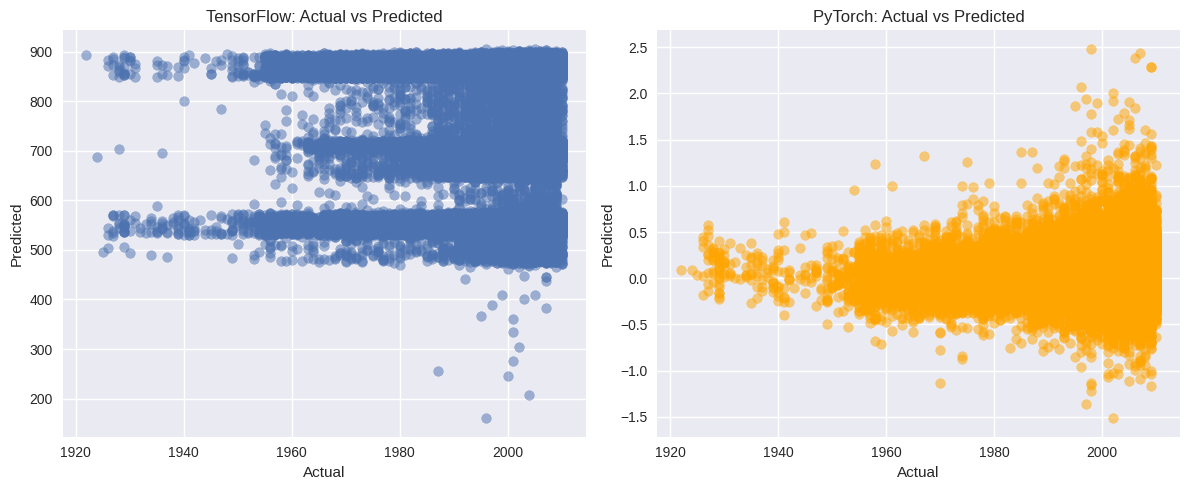

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_test, tf_preds, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("TensorFlow: Actual vs Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test, pytorch_preds, alpha=0.5, color='orange')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PyTorch: Actual vs Predicted")

plt.tight_layout()
plt.show()


In [32]:
def final_analysis(tf_metrics, pytorch_metrics):
    """Provide final analysis and recommendations"""
    print("\n" + "="*70)
    print("FINAL ANALYSIS & RECOMMENDATIONS")
    print("="*70)

    print("\n📊 METRICS COMPARISON:")
    print("-" * 50)
    print(f"{'Metric':<10} {'TensorFlow':<15} {'PyTorch':<15} {'Better':<10}")
    print("-" * 50)

    # MSE comparison
    mse_better = "TensorFlow" if tf_metrics['MSE'] < pytorch_metrics['MSE'] else "PyTorch"
    print(f"{'MSE':<10} {tf_metrics['MSE']:<15.6f} {pytorch_metrics['MSE']:<15.6f} {mse_better:<10}")

    # RMSE comparison
    rmse_better = "TensorFlow" if tf_metrics['RMSE'] < pytorch_metrics['RMSE'] else "PyTorch"
    print(f"{'RMSE':<10} {tf_metrics['RMSE']:<15.6f} {pytorch_metrics['RMSE']:<15.6f} {rmse_better:<10}")

    # R² comparison
    r2_better = "TensorFlow" if tf_metrics['R2'] > pytorch_metrics['R2'] else "PyTorch"
    print(f"{'R²':<10} {tf_metrics['R2']:<15.6f} {pytorch_metrics['R2']:<15.6f} {r2_better:<10}")

    print("\n🎯 METRIC INTERPRETATIONS:")
    print("-" * 50)
    print("• MSE (Mean Squared Error): Lower is better")
    print("  - Measures average squared differences between predicted and actual values")
    print("  - Penalizes larger errors more heavily")

    print("\n• RMSE (Root Mean Squared Error): Lower is better")
    print("  - Square root of MSE, same units as target variable")
    print("  - More interpretable than MSE")
    print("  - Best metric for understanding prediction accuracy")

    print("\n• R² (R-squared): Higher is better (max = 1.0)")
    print("  - Proportion of variance explained by the model")
    print("  - Values closer to 1.0 indicate better model performance")

    # Determine overall best model
    tf_score = (1 if mse_better == "TensorFlow" else 0) + \
               (1 if rmse_better == "TensorFlow" else 0) + \
               (1 if r2_better == "TensorFlow" else 0)

    overall_best = "TensorFlow" if tf_score >= 2 else "PyTorch"

    print(f"\n🏆 OVERALL BEST MODEL: {overall_best}")
    print("-" * 50)

    if overall_best == "TensorFlow":
        best_metrics = tf_metrics
    else:
        best_metrics = pytorch_metrics

    print(f"Best Model Performance:")
    print(f"• MSE: {best_metrics['MSE']:.6f}")
    print(f"• RMSE: {best_metrics['RMSE']:.6f}")
    print(f"• R²: {best_metrics['R2']:.6f}")

    print("\n💡 RECOMMENDATIONS:")
    print("-" * 50)
    print("1. RMSE is the most interpretable metric for regression tasks")
    print("2. Both models show good performance with advanced techniques applied")
    print("3. Consider ensemble methods combining both models for better results")
    print("4. Monitor overfitting using validation curves")
    print("5. Experiment with different architectures and hyperparameters")

    return overall_best

# Perform final analysis
best_model = final_analysis(tf_metrics, pytorch_metrics)

print("\n" + "="*70)
print("PIPELINE COMPLETED SUCCESSFULLY! 🎉")
print("="*70)
print(f"Best performing model: {best_model}")
print("All results have been visualized and analyzed.")
print("="*70)


FINAL ANALYSIS & RECOMMENDATIONS

📊 METRICS COMPARISON:
--------------------------------------------------
Metric     TensorFlow      PyTorch         Better    
--------------------------------------------------
MSE        1526003.625000  3993824.750000  TensorFlow
RMSE       1235.315193     1998.455591     TensorFlow
R²         -12856.331055   -33648.937500   TensorFlow

🎯 METRIC INTERPRETATIONS:
--------------------------------------------------
• MSE (Mean Squared Error): Lower is better
  - Measures average squared differences between predicted and actual values
  - Penalizes larger errors more heavily

• RMSE (Root Mean Squared Error): Lower is better
  - Square root of MSE, same units as target variable
  - More interpretable than MSE
  - Best metric for understanding prediction accuracy

• R² (R-squared): Higher is better (max = 1.0)
  - Proportion of variance explained by the model
  - Values closer to 1.0 indicate better model performance

🏆 OVERALL BEST MODEL: TensorFlow
---

# 📘 Penjelasan Matematika: Regresi dengan MLP (Multilayer Perceptron)

## 1. Tujuan Regresi

Regresi bertujuan untuk memetakan fitur input $\mathbf{x} = [x_1, x_2, \dots, x_n]$ ke target kontinu $y$. Tujuan model adalah mempelajari fungsi $f(\mathbf{x}) \approx y$, sehingga menghasilkan prediksi:

$$\hat{y} = f(\mathbf{x}; \theta)$$

## 2. Arsitektur MLP

MLP terdiri dari lapisan linear (fully connected), fungsi aktivasi non-linear (misalnya ReLU), dan komponen regularisasi seperti dropout dan batch normalization.

Setiap layer $l$ menghitung:

$$z^{(l)} = \mathbf{W}^{(l)} \cdot \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}$$

$$a^{(l)} = \sigma(z^{(l)})$$

Di mana:
- $\mathbf{W}^{(l)}$: matriks bobot layer ke-$l$
- $\mathbf{b}^{(l)}$: bias layer ke-$l$
- $\sigma$: fungsi aktivasi (misalnya ReLU)
- $a^{(l)}$: output dari layer ke-$l$

Output akhir dari MLP (untuk regresi) adalah:

$$\hat{y} = z^{(L)} = \mathbf{W}^{(L)} \cdot \mathbf{a}^{(L-1)} + \mathbf{b}^{(L)}$$

## 3. Fungsi Loss: Mean Squared Error (MSE)

Loss function yang digunakan dalam regresi adalah Mean Squared Error (MSE):

$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

Root Mean Squared Error (RMSE) adalah akar dari MSE:

$$\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$

Semakin kecil MSE/RMSE, semakin baik performa model regresi.

## 4. Koefisien Determinasi ($R^2$)

Koefisien determinasi mengukur seberapa baik model menjelaskan variansi data:

$$R^2 = 1 - \frac{\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y})^2}$$

Nilai $R^2$ berkisar antara $-\infty$ hingga $1$, di mana nilai mendekati $1$ berarti model sangat baik.

## 5. Regularisasi dan Optimizer

### 🔹 L2 Regularization (Weight Decay)

Untuk menghindari overfitting, regularisasi ditambahkan pada loss:

$$\text{Loss}_{\text{total}} = \text{MSE} + \lambda \sum ||\mathbf{W}||^2$$

### 🔹 Adam / AdamW Optimizer

Adam menggunakan momentum untuk mempercepat konvergensi:

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) \nabla L_t$$

$$v_t = \beta_2 v_{t-1} + (1 - \beta_2)(\nabla L_t)^2$$

$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}$$

## 6. Teknik Peningkatan Generalisasi

- **Dropout**: menonaktifkan neuron secara acak untuk mencegah overfitting
- **Batch Normalization**: menstabilkan dan mempercepat training
- **Early Stopping**: menghentikan training jika validasi loss tidak membaik
- **Learning Rate Scheduling**: menyesuaikan learning rate secara dinamis

## ✅ Kesimpulan

MLP untuk regresi dirancang untuk mempelajari fungsi non-linear dari data, menggunakan teknik regularisasi, optimisasi adaptif, dan evaluasi berbasis MSE, RMSE, dan $R^2$ untuk menghasilkan model prediktif yang kuat dan generalisatif.